In [1]:
from jax import grad, jit, vmap, pmap
from matplotlib import pyplot as plt
from jax.lib import xla_bridge
from jax import make_jaxpr
from jax import device_put
import jax.numpy as jnp
from jax import random
from jax import lax
import numpy as np

xla_bridge.get_backend().platform

CUDA backend failed to initialize: Unable to load CUDA. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


'cpu'

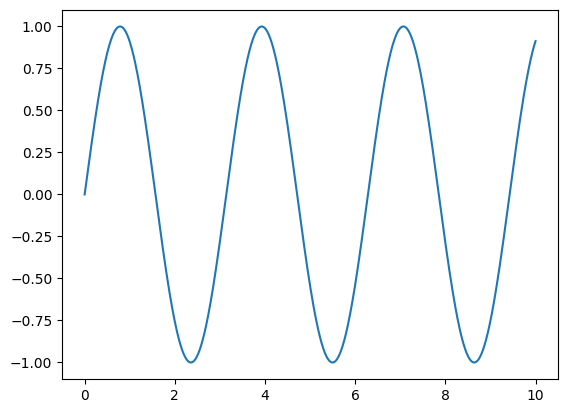

In [2]:
## jax는 numpy와 유사한 문법 구조를 가지고 있다.
x = np.linspace(0, 10, 1000)
y = np.sin(2 * x)
plt.plot(x, y)

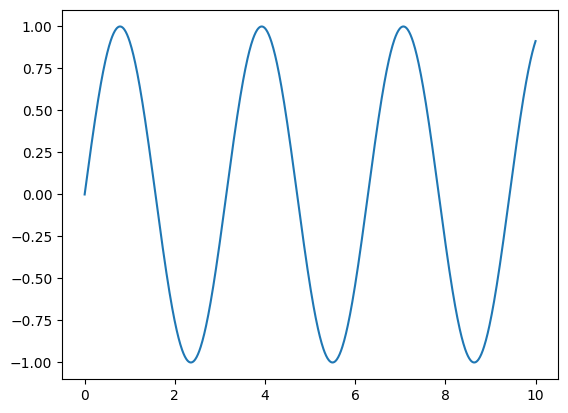

In [3]:
x = jnp.linspace(0, 10, 1000)
y = jnp.sin(2 * x)
plt.plot(x, y)

In [4]:
## JAX array는 불변 변수로 취급되기 때문에,
## numpy array 처럼 인덱싱을 통한 값 변경이 불가능하다.
size  = 10
index =  0
value = 23

In [5]:
x = np.arange(size)
print(x)
x[index] = value
print(x)

[0 1 2 3 4 5 6 7 8 9]
[23  1  2  3  4  5  6  7  8  9]


In [6]:
x = jnp.arange(size)
print(x)

try: x[index] = value
except Exception as e: print(f'\n\nerror : {e}\n\n')
    
## 대신 at, set 메소드를 이용해 변경할 수 있다.
x = x.at[index].set(value)
print(x)

[0 1 2 3 4 5 6 7 8 9]


error : '<class 'jaxlib.xla_extension.ArrayImpl'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html


[23  1  2  3  4  5  6  7  8  9]


In [7]:
## JAX에서는 random 숫자를 다르게 관리한다.
seed = 99
key  = random.PRNGKey(seed)

x    = random.normal(key, (10, ))
print(type(x), x)

<class 'jaxlib.xla_extension.ArrayImpl'> [-0.9513213   1.7788743  -1.4580659  -0.33244848  0.24782881  1.0122505
  0.7675285   0.3141468  -0.01992193  0.42590362]


In [8]:
## JAX는 GPU 가속을 이용할 수 있다.
size = 3_000
x_j  = jnp.linspace(0, size, 1000) 
x_n  =  np.linspace(0, size, 1000)

## GPU 속도 테스트
%timeit jnp.dot(x_j, x_j.T).block_until_ready()

## CPU 속도 테스트
%timeit np.dot(x_n, x_n.T)

## CPU 변수를 GPU로 속도 테스트
%timeit jnp.dot(x_n, x_n.T).block_until_ready()

22.9 µs ± 236 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
2.03 µs ± 38.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
16.6 µs ± 327 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [9]:
## jit을 이용해 함수를 컴파일하면, 처리 속도가 증가한다.
def visualize_fn(fn, l = -10, r = 10, n = 1000):
    
    x = np.linspace(l, r, num = n)
    y = fn(x)
    plt.plot(x, y); plt.show()

In [10]:
def selu(x, alpha = 1.67, lmbda = 1.05):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

selu_jit = jit(selu)